# Predicting project risk

The objetive of this work is design a machine learning model to predict the probability of a project having issues worth being featured in the project management risk report. The project risk report elaboration requires a significant effort, as the analysts have to peruse many reports and related documents to determine if a project has a high risk. So, by training a discriminative model, we will be able to prioritize the projects that statistically present a high risk profile and reduce the cost of report elaboration. We also want to explore the most significant factors that contribute to project risk, like managers, scope, seasonality, etc.

## The data

This work uses project data extracted from the Microsoft Project Server database, where the Chamber of Deputies corporate projects are stored. More specifically, we analyse data from  IT projects from March 2015 to August 2016.

The dataset `project-data.csv` used in this model is generated in the notebook `project-risk-features.ipynb`. This dataset has the following attributes:

* `project`: project identifier
* `risk`: label: 1 - high risk, 0 - low risk
* `status`: project status: {'tramitando para contratação', 'em andamento', 'não iniciado', 'sem relatório', 'atrasado', 'dependência externa', 'suspenso', 'em dependência externa', 'cancelado', 'em fase de encerramento', 'atividade', 'sem informação'}
* `compliance`: index for compliance with project management process
* `report_count`: number of reports available for the project
* `has_schedule`: 1 - project has schedule, 0 - otherwise
* `scope`: project scope: {"Corporativo", "Setorial", "Estruturante"}
* `office`: project sponsor office: {'Corporativo', 'CENIN', 'SECOM', 'DILEG', 'DG', 'DIRAD', 'DRH'}
* `month`: month of project report publication
* `year`: year of project report publication
* `day`: day of project report publication
* `risk_previous1`: project appeared in the risk report in the last month
* `risk_previous2`: project appeared in the risk report in the last two months
* `risk_previous3`: project appeared in the risk report in the last three months
* `project_risk_likelihood`: maximum likelihood risk probability estimation (with Laplace smoothing)
* `report_word_count`: number of words in report
* `poa_word_count`: number of words in "points of attention" section
* `estimated_days_finish`: estimated days to finish project
* `manager_risk_likelihood`: maximum likelihood risk probability estimation for managers (with Laplace smoothing)
* `manager_project_count`: number of projects the manager is responsible in a given month

## Preprocessing

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import util
from IPython.display import display
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.cross_validation import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

data = pd.read_csv('project-data.csv')

# encoding categorical data
data = pd.concat([data, pd.get_dummies(data.status)], axis=1)
data = pd.concat([data, pd.get_dummies(data.office.str.lower())], axis=1)

# filling missing values
data['compliance'].fillna(data['compliance'].mean(), inplace=True)
data['report_count'].fillna(data['report_count'].mean(), inplace=True)

# standardization
numerical_features = ['day', 'report_word_count', 'poa_word_count', 'compliance',
                      'estimated_days_finish', 'manager_risk_likelihood', 'manager_project_count',
                      'project_risk_likelihood', 'report_count']

std_scale = StandardScaler().fit(data[numerical_features])
features_scaled = pd.DataFrame(std_scale.transform(data[numerical_features]), 
                           columns=numerical_features, index=data.index)
data = pd.concat([data[data.columns.drop(numerical_features)], features_scaled], axis=1)

display(data.head(), data.shape)

,project,risk,status,has_schedule,scope,office,month,year,risk_previous1,risk_previous2,...,secom,day,report_word_count,poa_word_count,compliance,estimated_days_finish,manager_risk_likelihood,manager_project_count,project_risk_likelihood,report_count
0,d4a12fad3a1553d1aa8d945c6d8c46e4b733ae5e,1.0,tramitando para contratação,1,Corporativo,Corporativo,3,2015,0,0,...,0.0,-4.010050e-16,0.007585,-0.824473,0.722363,0.000000,-0.252429,-0.784835,-0.172296,1.947849
1,d4a12fad3a1553d1aa8d945c6d8c46e4b733ae5e,1.0,tramitando para contratação,1,Corporativo,Corporativo,4,2015,1,0,...,0.0,-1.257328e+00,-0.015689,-0.824473,0.722363,0.046109,0.593820,-0.784835,0.749906,1.947849
2,d4a12fad3a1553d1aa8d945c6d8c46e4b733ae5e,1.0,tramitando para contratação,1,Corporativo,Corporativo,5,2015,1,1,...,0.0,-6.929637e-01,0.263596,-0.824473,0.722363,0.020124,1.099686,-0.784835,1.392062,1.947849
3,d4a12fad3a1553d1aa8d945c6d8c46e4b733ae5e,0.0,em andamento,1,Corporativo,Corporativo,6,2015,1,1,...,0.0,1.338748e+00,-0.411344,1.192079,0.722363,-0.016255,1.444595,0.706060,1.872233,1.947849
4,d4a12fad3a1553d1aa8d945c6d8c46e4b733ae5e,0.0,em andamento,1,Corporativo,Corporativo,6,2015,1,1,...,0.0,-1.821692e+00,-0.364796,0.202135,0.722363,0.004533,1.444595,0.706060,1.872233,1.947849


(1022, 39)

## Train/test split

In [2]:
train_selector = (data.year == 2015) | ((data.year == 2016) & (data.month <= 3))

train = data[train_selector]
test = data[~train_selector & (data.risk >= 0)]
unlabeled = data[data.risk == -1]

print("Training set shape {}".format(train.shape))
print("Test set shape {}".format(test.shape))
print("Unlabeled set shape {}".format(unlabeled.shape))

features = data.columns.drop(['project', 'scope', 'office', 'status', 'risk'])

Training set shape (733, 39)
Test set shape (229, 39)
Unlabeled set shape (60, 39)


## Data visualization

Using PCA and t-SNE to visualize data. It's interesting how t-SNE seems to better capture non-linear structure.

See http://scikit-learn.org/stable/modules/manifold.html#t-sne for more information.

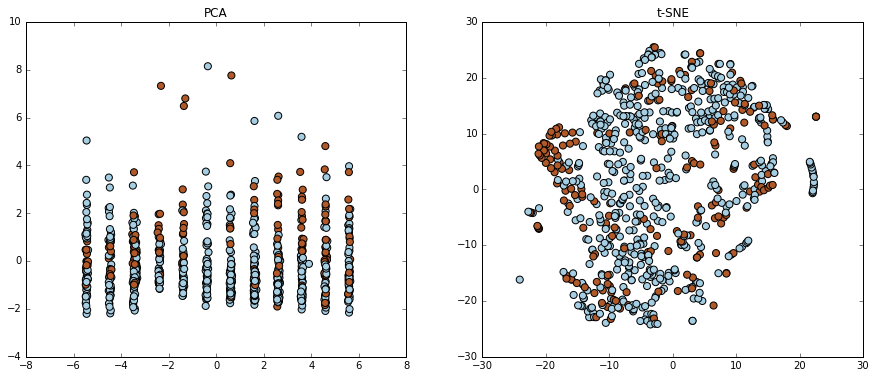

In [9]:
util.visualize(train[features], train.risk)

## Training with all features

### Baseline model

First we train and evaluate classifiers using k-fold cross-validation (without hyperparameter tuning) and ROC AUC as performance metric.

In [7]:
clfs = [SVC(class_weight='balanced', kernel='rbf', probability=True),
        KNeighborsClassifier(n_neighbors=15),
        GaussianNB(),
        ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=17)]

scores = util.benchmark(clfs, train[features], train.risk)
print("Scores for each classifier: %s" % scores)
print("Average Score: %0.3f (+/-%0.03f) for features %r" % (np.mean(scores), np.std(scores) * 2, 
                                                            features.values.tolist()))

Scores for each classifier: [0.59851548059149717, 0.55779228280961179, 0.52387072550831792, 0.56870475200246462]
Average Score: 0.562 (+/-0.053) for features ['has_schedule', 'month', 'year', 'risk_previous1', 'risk_previous2', 'risk_previous3', 'atividade', 'atrasado', 'cancelado', 'dependência externa', 'em andamento', 'em dependência externa', 'em fase de encerramento', 'não iniciado', 'sem informação', 'sem relatório', 'suspenso', 'tramitando para contratação', 'cenin', 'corporativo', 'dg', 'dileg', 'dirad', 'drh', 'secom', 'day', 'report_word_count', 'poa_word_count', 'compliance', 'estimated_days_finish', 'manager_risk_likelihood', 'manager_project_count', 'project_risk_likelihood', 'report_count']


### Hyperparameter tuning

Using grid search to adjust the models' hyperparameters should improve our score.

In [8]:
clfs = [GridSearchCV(SVC(class_weight='balanced', probability=True),
                   param_grid=dict(C=[1, 10, 100], gamma=[0.001, 0.0001],
                                   kernel=['rbf']), cv=6, scoring='roc_auc'),
        GridSearchCV(KNeighborsClassifier(n_neighbors=5),
                   param_grid=dict(n_neighbors=[10, 15, 20]), cv=6, scoring='roc_auc'),
        GaussianNB(),
        GridSearchCV(ExtraTreesClassifier(n_estimators=100, class_weight='balanced',
                                          random_state=17),
                   param_grid=dict(n_estimators=[50, 100, 200]), cv=6, scoring='roc_auc')
        ]

scores = util.benchmark(clfs, train[features], train.risk)
print("Scores for each classifier: %s" % scores)
print("Average Score: %0.3f (+/-%0.03f) for features %r" % (np.mean(scores), np.std(scores) * 2, 
                                                            features.values.tolist()))

Scores for each classifier: [0.6989235450013076, 0.70453030702433839, 0.52387072550831792, 0.66591257764518341]
Average Score: 0.648 (+/-0.147) for features ['has_schedule', 'month', 'year', 'risk_previous1', 'risk_previous2', 'risk_previous3', 'atividade', 'atrasado', 'cancelado', 'dependência externa', 'em andamento', 'em dependência externa', 'em fase de encerramento', 'não iniciado', 'sem informação', 'sem relatório', 'suspenso', 'tramitando para contratação', 'cenin', 'corporativo', 'dg', 'dileg', 'dirad', 'drh', 'secom', 'day', 'report_word_count', 'poa_word_count', 'compliance', 'estimated_days_finish', 'manager_risk_likelihood', 'manager_project_count', 'project_risk_likelihood', 'report_count']


## Feature selection

Let's try to select only the most significant features to avoid noise that degrades the performance of our model.

### Univariate feature selection

First we try univariate statistical tests.
See http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection for more information.

In [13]:
best_score = 0
best_features = None
for k in range(1, 15):        
    selector = SelectKBest(f_classif, k=k)
    selector.fit(train[features], train['risk'])
    bestk_features = features[selector.get_support()]

    scores = util.benchmark(clfs, train[bestk_features], train.risk, show_confusion=False)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        best_features = bestk_features

print("Selected features: %s" % best_features.values)

Selected features: ['month' 'risk_previous1' 'risk_previous2' 'não iniciado' 'sem relatório'
 'suspenso' 'cenin' 'corporativo' 'drh' 'manager_risk_likelihood'
 'manager_project_count' 'project_risk_likelihood']


### Visualization

With less features we can see a more clear structure using t-SNE.

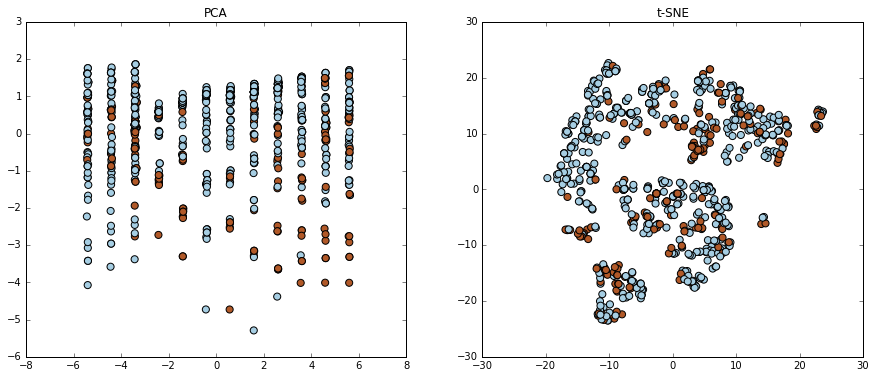

In [15]:
util.visualize(train[best_features], train.risk)

### Training and cross-validation

And a slightly better score from cross-validation.

In [21]:
scores = util.benchmark(clfs, train[best_features], train.risk)
print("Scores for each classifier: %s" % scores)
print("Average Score: %0.3f (+/-%0.03f) for %r" % (np.mean(scores), np.std(scores) * 2, best_features.values))

Scores for each classifier: [0.72007870294023091, 0.69851700094281954, 0.65841131392483043, 0.67469170968488834]
Average Score: 0.688 (+/-0.047) for array(['month', 'risk_previous1', 'risk_previous2', 'não iniciado',
       'sem relatório', 'suspenso', 'cenin', 'corporativo', 'drh',
       'manager_risk_likelihood', 'manager_project_count',
       'project_risk_likelihood'], dtype=object)


## Model-based selection

Another approach: using linear model with L1 regularization to obtain sparse solution.

See http://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection for more information.

In [35]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(train[features], train['risk'])
model_selector = SelectFromModel(lsvc, prefit=True)
X_new = selector.transform(train[features])
model_features = features[model_selector.get_support()]
print("Selected features: %s" % model_features.values)

Selected features: ['has_schedule' 'month' 'year' 'risk_previous1' 'risk_previous2'
 'risk_previous3' 'em andamento' 'não iniciado' 'sem relatório' 'suspenso'
 'cenin' 'corporativo' 'day' 'report_word_count' 'compliance'
 'estimated_days_finish' 'manager_risk_likelihood' 'manager_project_count'
 'report_count']


### Visualization

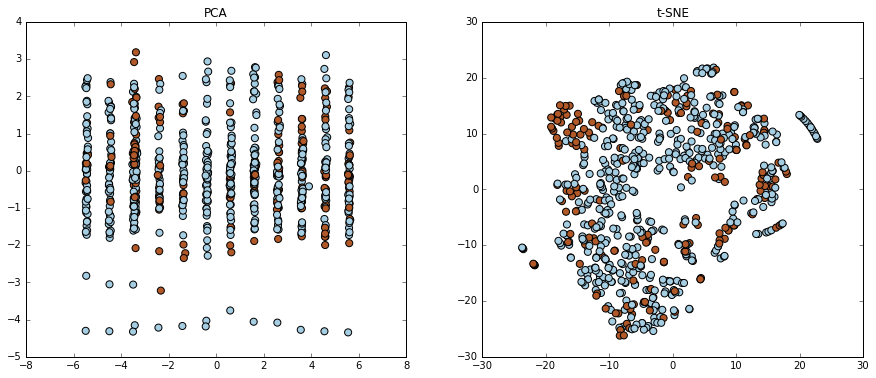

In [23]:
util.visualize(train[model_features], train.risk)

### Training and cross-validation

In [25]:
scores = util.benchmark(clfs, train[model_features], train.risk)
print(scores)
print("Average Score: %0.3f (+/-%0.03f) for %r" % (np.mean(scores), np.std(scores) * 2, model_features.values))

[0.71480552473901726, 0.70137835296430107, 0.60867221195317334, 0.68938288528585256]
0.679 (+/-0.083) for Index(['has_schedule', 'month', 'year', 'risk_previous1', 'risk_previous2',
       'risk_previous3', 'em andamento', 'não iniciado', 'sem relatório',
       'suspenso', 'cenin', 'corporativo', 'day', 'report_word_count',
       'compliance', 'estimated_days_finish', 'manager_risk_likelihood',
       'manager_project_count', 'report_count'],
      dtype='object')


## Combining features

Since both feature selection methods results in model improvement, we do an intersection of the two selected feature sets.

### Visualization

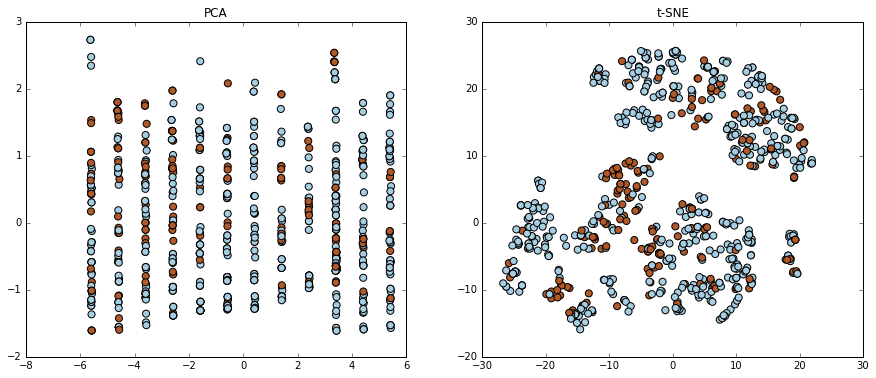

In [33]:
combined_features = list(set(best_features) & set(model_features))
util.visualize(train[combined_features], train.risk)

### Training and cross-validation

The intersection of features selected from univariate and model-based selection seems to significantly improve the model.

In [34]:
scores = util.benchmark(clfs, train[combined_features], train.risk)
print("Scores for each classifier: %s" % scores)
print("Average Score: %0.3f (+/-%0.03f) for %r" % (np.mean(scores), np.std(scores) * 2, combined_features))

Scores for each classifier: [0.74226486148382465, 0.71403607950333736, 0.65521988601355508, 0.68793660059434281]
Average Score: 0.700 (+/-0.064) for ['sem relatório', 'risk_previous2', 'manager_project_count', 'não iniciado', 'risk_previous1', 'corporativo', 'month', 'manager_risk_likelihood', 'cenin', 'suspenso']


## Ensemble classifier

Now, instead of just choosing the algorithm that results in best cross-validation score we can combine the results of the classifiers to create a better ensemble model. See http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier.

In [53]:
clfs = [
        SVC(class_weight='balanced', probability=True, kernel='rbf'),
        KNeighborsClassifier(n_neighbors=5),
        GaussianNB(),
        ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=17)
        ]

eclf = VotingClassifier(estimators=[(type(clf).__name__, clf) for clf in clfs], 
                          voting='soft', weights=[3,3,1,1])

params = {'SVC__C': [1, 10, 100], 'SVC__gamma': [0.001, 0.0001], 'SVC__kernel': ['rbf'],
          'ExtraTreesClassifier__n_estimators': [50, 100, 200],
          'KNeighborsClassifier__n_neighbors': [10, 15, 20]
         }

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=6, scoring='roc_auc')

# we can adjust sensitivity by changing the threshold, since we have imbalanced data
scores = util.benchmark(grid, train[combined_features], train.risk, threshold=0.5, show_confusion=True, 
                        show_report=True)
print("Score: %0.3f" % (np.mean(scores)))

Classification report for classifier GridSearchCV(cv=6, error_score='raise',
       estimator=VotingClassifier(estimators=[('SVC', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('KNeighborsClassifier', KNeighborsClassifier(alg...stimators=100, n_jobs=1,
           oob_score=False, random_state=17, verbose=0, warm_start=False))],
         voting='soft', weights=[3, 3, 1, 1]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ExtraTreesClassifier__n_estimators': [50, 100, 200], 'SVC__C': [1, 10, 100], 'SVC__gamma': [0.001, 0.0001], 'SVC__kernel': ['rbf'], 'KNeighborsClassifier__n_neighbors': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0):
             precision    recall  f1-score   support

        0.0       0.86      0.97      0.91       541
        1

## Adjusting the classification threshold

Although our model has a decent overall performance, we need to adjust the model sensitivity, since it is more important in our problem to detect most of the high risk projects. A moderate amount of false positives is tolerated. For a more detailed discussion on how to adjust model sensitivity see: https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb.

In [56]:
grid.best_estimator_.fit(train[combined_features], train.risk)
pred_prob_1 = grid.best_estimator_.predict_proba(train[combined_features])[:, 1]

# we can adjust sensitivity by changing the default threshold (0.5), since we have imbalanced data
predicted = binarize([pred_prob_1], 0.20)[0]

print("Classification report:\n%s"
              % (metrics.classification_report(train.risk, predicted)))
print("Confusion matrix:\n%s\n" % metrics.confusion_matrix(train.risk, predicted))

Classification report:
             precision    recall  f1-score   support

        0.0       0.98      0.67      0.79       541
        1.0       0.50      0.96      0.66       192

avg / total       0.85      0.74      0.76       733

Confusion matrix:
[[360 181]
 [  8 184]]



## Evaluating generalization on held-out data

In [48]:
grid.best_estimator_.fit(train[combined_features], train.risk)
pred_prob_1 = grid.best_estimator_.predict_proba(test[combined_features])[:, 1]

# we can adjust sensitivity by changing the threshold, since we have imbalanced data
predicted = binarize([pred_prob_1], 0.20)[0]

print("Classification report:\n%s"
              % (metrics.classification_report(test.risk, predicted)))
print("Confusion matrix:\n%s\n" % metrics.confusion_matrix(test.risk, predicted))

Classification report:
             precision    recall  f1-score   support

        0.0       0.94      0.70      0.80       197
        1.0       0.28      0.72      0.40        32

avg / total       0.85      0.70      0.75       229

Confusion matrix:
[[138  59]
 [  9  23]]



## Feature importances

Finally, we use a Random Forest to get the relative importances of the features. The most significant features seems to be related to managers, seasonality (month) and markovian features (risk_previous1).

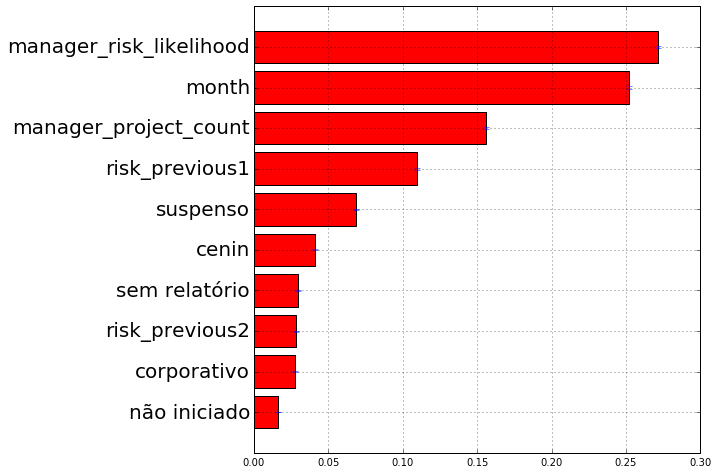

In [51]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=17)

forest.fit(train[combined_features], train.risk)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)#[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(train[combined_features].shape[1]):
#    print("%d. feature %s (%f)" % (f + 1, combined_features[indices[f]], 
#                                   importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
#plt.title("Importância das variáveis")
plt.barh(range(train[combined_features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(train[combined_features].shape[1]),
           [combined_features[i] for i in indices], fontsize=20,)
plt.ylim([-1, train[combined_features].shape[1]])
plt.grid()
plt.show()

## Conclusion

Even with very few data, our model is able to detect a high percentage of high risk projects (~70% on test data) and reduce the amount of projects to be analyzed in approximately 60%. To further improve this model we need:

* More project data
* Use Natural Language Processing to take into account semantic information in project reports, which may be used to only to detect but also to automatically classify risks in different categories.



In [ ]:
'''pred_prob_1 = grid.best_estimator_.predict_proba(unlabeled[combined_features])[:, 1]
predicted = binarize([pred_prob_1], 0.20)[0]
predictions = data.loc[unlabeled[predicted == 1].index]
predictions.drop_duplicates(['project'], inplace=True)
import datetime
predictions.to_csv("risk_%s.csv" % datetime.date.today(), index=False)
display(predictions.head(), predictions.shape)'''